## Example use: impact modelling - solar energy generation

Author: Karin van der Wiel, 12-07-2022

PV energy model from: Van der Wiel et al. (2019, RSER, http://doi.org/10.1016/j.rser.2019.04.065).

Aim of the case study: show the advantage of large ensemble modelling also for climate-impact studies.

#### Preparation

In [1]:
## import packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

LENTIS_directory = '/net/pc200021/nobackup_1/users/muntjewe/LENTIS/ec-earth/cmorised_by_var/'
output_directory = '/net/pc170544/nobackup/users/wiel/LENTIS/datapaper/'

def daily_annual_cycle(da,rm):
    """ Compute daily mean climatology (taking into account leap days) """
    # compute climatology
    month_day_str = xr.DataArray(da.indexes['time'].strftime('%m-%d'),coords=da.coords,name='month_day_str')
    da_clim = da.groupby(month_day_str).mean('time')
    da_clim = da_clim.rename({'month_day_str':'time'})
    clim_timeaxis = pd.date_range(start='1/1/2000', end='31/12/2000', freq='D').astype('datetime64[ns]')
    da_clim = da_clim.assign_coords({'time':clim_timeaxis})
    # apply running mean
    da_clim_thrice = np.tile(da_clim.values,3)
    da_clim[:] = np.convolve(da_clim_thrice, np.ones(rm)/rm, mode='full')[len(da_clim):2*len(da_clim)]
    return da_clim

#### Open pre-computed energy-impact data

In [2]:
ds_energy = xr.open_mfdataset(f"{output_directory}energy_day_PD_52.3N_4.9E_P*.nc")
da_solar_pot = ds_energy['PVpot'].load()
da_rsds = ds_energy['rsds'].load()
da_cell_temp = ds_energy['PVcell_temp'].load()
da_dayhours = ds_energy['dayhours'].load()

#### Plot figure: compounding variables scatter-density plots 

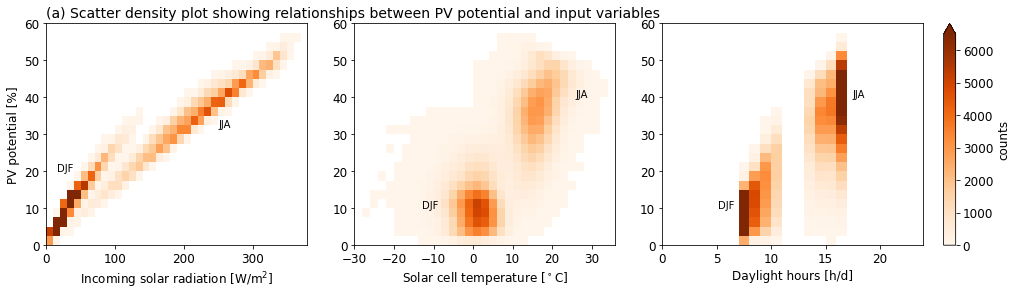

In [3]:
# Only show DJF-JJA data points
def sel_months(da):
    mask_winter = da.where(da.time.dt.season=='DJF')
    mask_summer = da.where(da.time.dt.season=='JJA')
    da_mask = xr.concat([mask_winter,mask_summer],dim='time')
    da_mask = da_mask.dropna(dim='time')
    da_mask_1Darray = np.reshape(da_mask.values,(len(da_mask.parent)*len(da_mask.member)*len(da_mask.time)))
    return da_mask_1Darray
da_solar_pot_DJFJJA = sel_months(da_solar_pot) *100
da_rsds_DJFJJA = sel_months(da_rsds)
da_cell_temp_DJFJJA = sel_months(da_cell_temp)
da_dayhours_DJFJJA = sel_months(da_dayhours)

# Plot
fig = plt.figure(figsize=(14,4))
plt.subplots_adjust(left=0.04, bottom=0.13, right=.91, top=0.9, wspace=0.18)
MAX = round(len(da_solar_pot_DJFJJA) /45 /100)*100
# 2D histogram/scatter plot: solar vs rsds
ax = plt.subplot(1,3,1)
plt.hist2d(da_rsds_DJFJJA,da_solar_pot_DJFJJA,cmap='Oranges',range=[[0,380],[0,60]],bins=(38,24),norm=colors.Normalize(vmin=0,vmax=MAX),cmin=1) # colors.LogNorm
plt.text(15,20,'DJF',fontsize=10)
plt.text(250,32,'JJA',fontsize=10)
plt.title('(a) Scatter density plot showing relationships between PV potential and input variables',loc='left',fontsize=14)
plt.xlabel('Incoming solar radiation [W/m$^2$]',fontsize=12)
plt.ylabel('PV potential [%]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# solar vs TASday
ax = plt.subplot(1,3,2)
plt.hist2d(da_cell_temp_DJFJJA,da_solar_pot_DJFJJA,cmap='Oranges',range=[[-30,36],[0,60]],bins=(33,24),norm=colors.Normalize(vmin=0,vmax=MAX),cmin=1)
plt.text(-13,10,'DJF',fontsize=10)
plt.text(26,40,'JJA',fontsize=10)
plt.xlabel('Solar cell temperature [$^\circ$C]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# solar vs wind
ax = plt.subplot(1,3,3)
im = plt.hist2d(da_dayhours_DJFJJA,da_solar_pot_DJFJJA,cmap='Oranges',range=[[0,24],[0,60]],bins=(24,24),norm=colors.Normalize(vmin=0,vmax=MAX),cmin=1)
plt.text(5.1,10,'DJF',fontsize=10)
plt.text(17.5,40,'JJA',fontsize=10)
plt.xlabel('Daylight hours [h/d]',fontsize=12)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
cbar_ax = fig.add_axes([.93,0.13,.012,.77]) #xpos,ypos,xlen,ylen
cbar = plt.colorbar(orientation='vertical',extend='max',cax=cbar_ax)
cbar.set_label('counts', rotation=90, fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.savefig(f"fig_example_impact_PV_a.pdf")

plt.show()

#### Plot figure: time series, extreme events (meteorological vs impact)

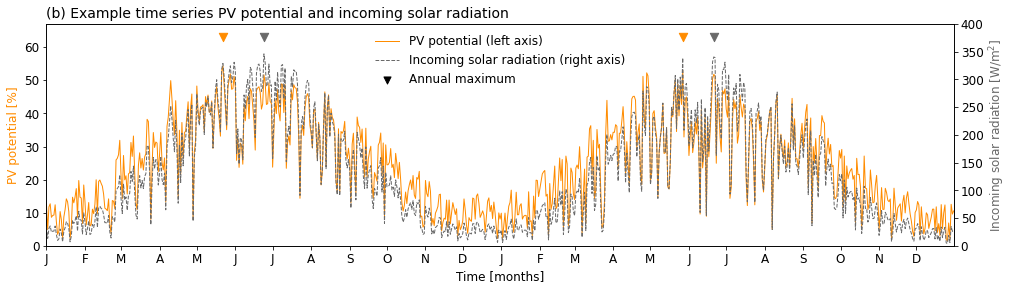

In [4]:
# In time series, show first two years and annual-max extreme events
N_years = 2
da_solar_pot_part = da_solar_pot.sel(parent=1,member=1,time=slice('2000-01-01',f"{1999+N_years}-12-31"))
da_rsds_part = da_rsds.sel(parent=1,member=1,time=slice('2000-01-01',f"{1999+N_years}-12-31"))
x_values = np.arange(0,N_years-1,(N_years-1)/len(da_solar_pot_part))

def find_annmax(da):
    annmax_index = np.where(da==da.groupby(da.time.dt.year).max())[0]
    return annmax_index

PVpot_annmax_index = find_annmax(da_solar_pot_part)
rsds_annmax_index = find_annmax(da_rsds_part)

fig,ax1 = plt.subplots(figsize=(14,4))
plt.subplots_adjust(left=0.05, bottom=0.13, right=.95, top=0.9)
colour1 = 'darkorange'
colour2 = 'dimgrey'
# line1
ax1.plot(x_values,da_solar_pot_part.values*100,color=colour1,linewidth=1,label='PV potential (left axis)')
# events
ax1.scatter(x_values[PVpot_annmax_index],np.repeat(63,N_years),color=colour1,marker='v',s=70)
ax1.scatter(x_values[rsds_annmax_index],np.repeat(63,N_years),color=colour2,marker='v',s=70)
plt.ylim(0,67)
plt.title('(b) Example time series PV potential and incoming solar radiation',loc='left',fontsize=14)
plt.xlabel('Time [months]',fontsize=12)
plt.ylabel('PV potential [%]',fontsize=12,color=colour1)
# line2
ax2 = ax1.twinx()
ax2.plot([-10],[0],color=colour1,linewidth=1,label='PV potential (left axis)') # fake for legend
ax2.plot(x_values,da_rsds_part.values,color=colour2,linewidth=1,linestyle='--',label='Incoming solar radiation (right axis)')
ax2.scatter([-10],[0],color='black',marker='v',s=50,label='Annual maximum') # fake for legend
plt.ylabel('Incoming solar radiation [W/m$^2$]',fontsize=12,color=colour2)
plt.ylim(0,400)
# annotation etc
plt.xticks(x_values[np.where(da_rsds_part.time.dt.day==1)[0][0:N_years*12]],'JFMAMJJASOND'*N_years)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
plt.xlim(0,x_values[-1])
plt.legend(frameon=False,fontsize=12)
plt.savefig(f"fig_example_impact_PV_b.pdf")